In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(3554)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


In [69]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:75% !important; }</style>"))

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [2]:
#Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

### Load Data

In [35]:
data = pd.read_json("Data/train/train.json")
train_df = data
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
#merge bands and create 3rd and 4th channel
band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75)
band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75)
band_3 = (band_1 + band_2)/2
band_4 = -(band_1 * band_2) #negate band_4
band_5 = band_1 - band_2
X = np.stack((band_1,band_2,band_3,band_4,band_5),axis=3)
X.shape

(1604, 75, 75, 5)

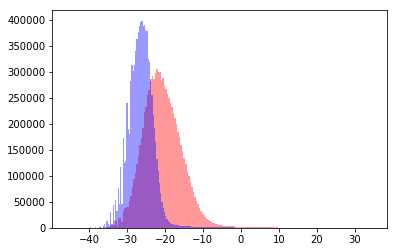

In [15]:
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(),bins=200, color="blue", alpha=0.4)
plt.show()

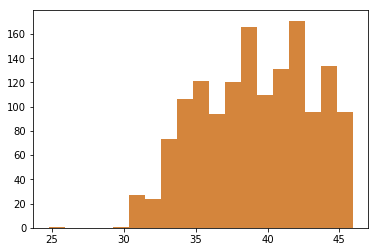

In [47]:
plt.hist(train_df['inc_angle'][train_df['inc_angle'] != 'na'],bins='auto', alpha=0.75)
plt.show()

In [96]:
train_df['inc_angle'][train_df['inc_angle'] == 'na'] = None

D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [95]:
train_df['inc_angle_f'] = train_df['inc_angle'].astype(np.float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 6 columns):
band_1         1604 non-null object
band_2         1604 non-null object
id             1604 non-null object
inc_angle      1471 non-null object
is_iceberg     1604 non-null int64
inc_angle_f    1471 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 75.3+ KB


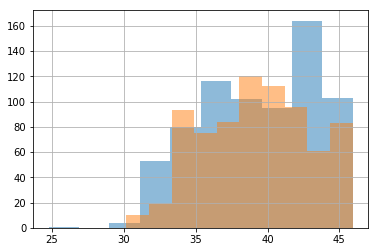

In [104]:
train_g = train_df.groupby('is_iceberg')
train_g['inc_angle_f'].hist(alpha=0.5)
plt.show()

In [98]:
train_df['inc_angle_f'].median()

39.5015

In [25]:
print(X.max())
print(X.min())
print(X.std())

407.145967026
-1525.93325949
228.401372354


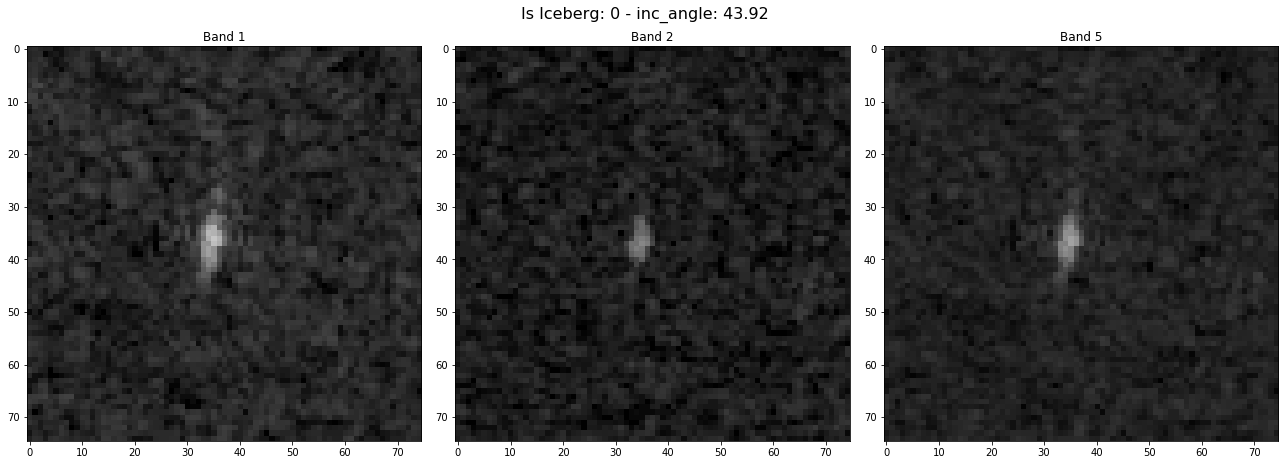

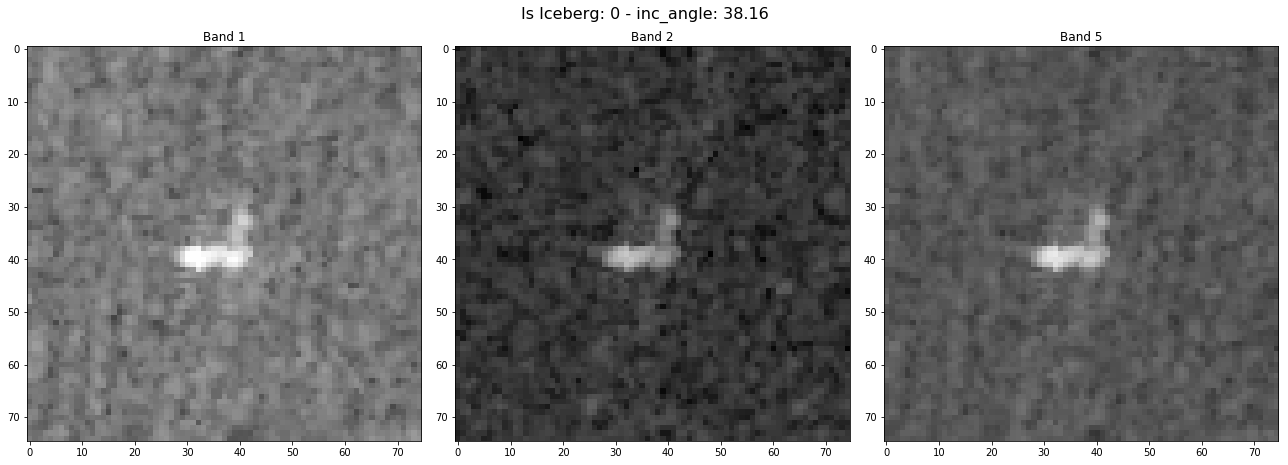

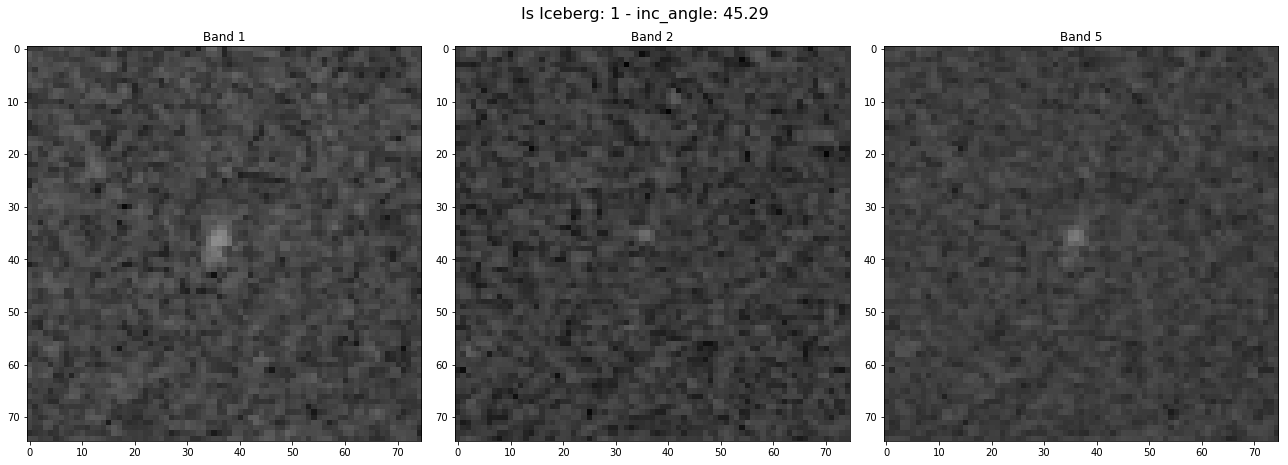

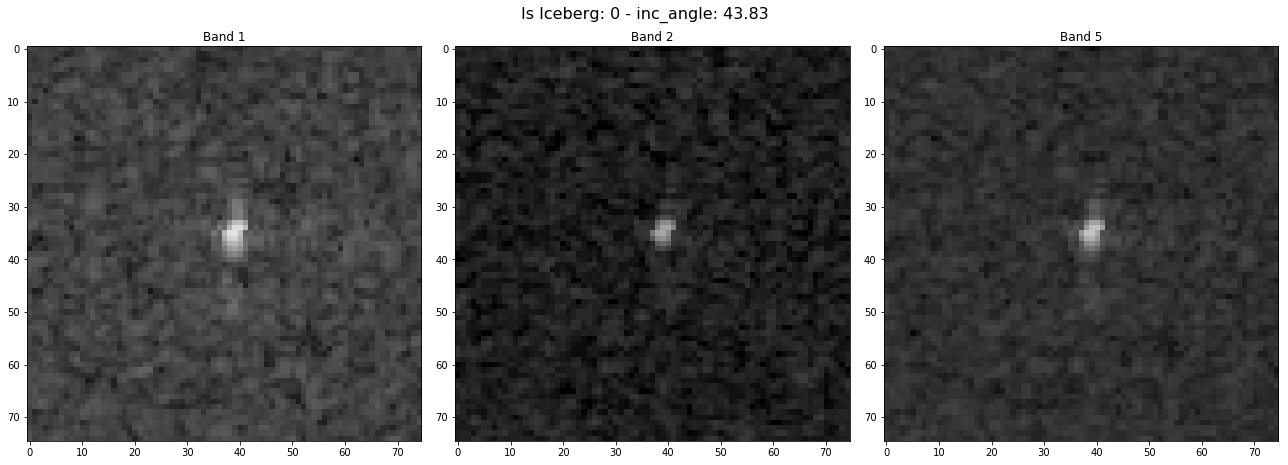

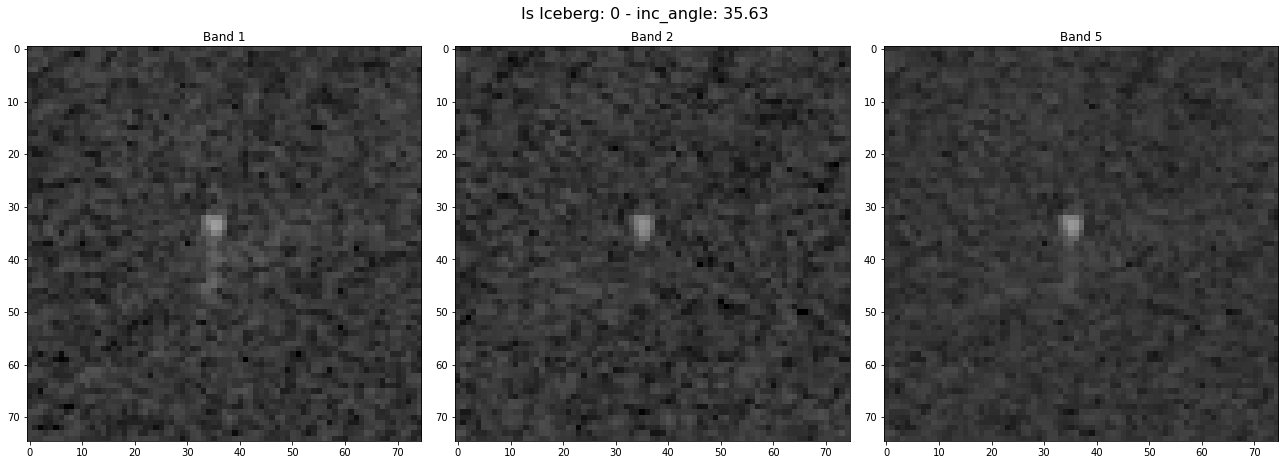

In [78]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(241)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(242)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(243)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    ax3 = fig.add_subplot(244)
    ax3.set_title("Band 4")
    ax3.imshow(band_4[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
def plot_bands125(index, cmap="gray"):
    fig = plt.figure(figsize=(18,14))
    fig.suptitle("Is Iceberg: %x - inc_angle: %.2f" % (train_df.loc[index,'is_iceberg'], train_df.loc[index,'inc_angle']), fontsize=16)
    ax1 = fig.add_subplot(231)
    ax1.set_title("Band 1")
    cax1 = ax1.imshow(band_1[index], cmap=cmap, vmin=-35, vmax=10)
    #cax1.colorbar()
    ax2 = fig.add_subplot(232)
    ax2.set_title("Band 2")
    cax2 = ax2.imshow(band_2[index], cmap=cmap, vmin=-35, vmax=10)
    #cax2.colorbar()
    ax3 = fig.add_subplot(233)
    ax3.set_title("Band 5")
    cax3 = ax3.imshow(band_3[index], cmap=cmap, vmin=-35, vmax=10)
    fig.tight_layout()
    #cax3.colorbar()
    plt.show()

for index in train_df.index[:5]:    
    plot_bands125(index,cmap="gray")


#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(band_1[0,:,:], 'not-iceberg')
plotmy3d(band_2[0,:,:], 'not-iceberg')